<a href="https://colab.research.google.com/github/yslk327/Flood_Map_Metrics/blob/main/MD_RF_classifier_Sentinel_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Environment Setup and Initialization**



In [1]:
# Install the necessary libraries
!pip install earthengine-api geemap
!pip install pandas
!pip install rasterio
!pip install numpy
#pip install --upgrade geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.3 MB/s eta 0:00:00


In [2]:

# Import the libraries

import ee
import geemap
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive


# Earth Engine Authentication
ee.Authenticate()
ee.Initialize(project='ee-yassineloukili')


In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading Sentinel-1 Data and Study Area Definitions**

In [13]:
# Loading Sentinel-1 Image Collections
S1 = ee.ImageCollection("COPERNICUS/S1_GRD")

# Load image and sample data: Tetouan, Morocco
# Define SAR parameters
polarization = "VH"
pass_direction = "DESCENDING"

# Define date range for the Tetouan-Morocco area
beforeStart = '2021-01-07'
beforeEnd = '2021-01-13'
afterStart = '2021-01-13'
afterEnd = '2021-01-18'

#geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/AnalysisExtent_Tetouan")
geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/extent_Tetouan")  # Study area Tetouan, Morocco
water_extent_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_Extent_Tetouan")  #  Flooded area Tetouan, Morocco
other_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/other_data_tetouan_400")  # Other training sample Tetouan, Morocco
water_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_data2_tetouan_300")  # Water training sample Tetouan, Morocco

"""
# Load image and sample data: Matam, Senegal

# Define SAR parameters
polarization = "VV"
pass_direction = "ASCENDING"

# Define date range for the Senegal area
beforeStart = '2024-10-10'
beforeEnd = '2024-10-20'
afterStart = '2024-10-21'
afterEnd = '2024-10-30'

#geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/AnalysisExtent_Matam_Senegal_20241025")  #  Study area Matam, Senegal
#water_extent_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_Extent_Matam_Senegal_20241025")  #  Flooded area Matam, Senegal-20241025
geometry_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/AnalysisExtent_MatamDepartment_20241020")  #  Study area Matam, Senegal
water_extent_area = ee.FeatureCollection("projects/ee-yassineloukili/assets/WaterExtent_MatamDepartment_20241020")  #  Flooded area Matam, Senegal-20241020
other_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/other_data_Senegal_400")  # Other training sample Matam, Senegal
water_data = ee.FeatureCollection("projects/ee-yassineloukili/assets/water_data_Senegal_300")  # Water training sample Matam, Senegal

"""

# *********************************Load Sentinel-1 Images *********************************
collection_S1 = (S1
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('orbitProperties_pass', pass_direction))
    .filterMetadata('resolution_meters', 'equals', 10)
    .filterBounds(geometry_area)
    .select(polarization)
)

# ********************************* Filter Sentinel-1 by Date *********************************
before_S1_date = collection_S1.filterDate(beforeStart, beforeEnd)
after_S1_date = collection_S1.filterDate(afterStart, afterEnd)

# ********************************* Create Before and After Mosaics *********************************
before_S1 = before_S1_date.mosaic().clip(geometry_area)
after_S1 = after_S1_date.mosaic().clip(geometry_area)

# Apply a speckle noise reduction filter
SMOOTHING_RADIUS = 50
before_S1_filtered = before_S1.focal_mean(SMOOTHING_RADIUS, 'circle', 'meters')
after_S1_filtered = after_S1.focal_mean(SMOOTHING_RADIUS, 'circle', 'meters')


# Combine all data into a single image collection
allcollection =  ee.Image.cat(before_S1_filtered,after_S1_filtered)
# Select bands to use in the classifier
print("Bands in the merged collection:", allcollection.bandNames().getInfo())

bandNamesS1 = [polarization]

Bands in the merged collection: ['VH', 'VH_1']


**Merging Training Data and Sampling Image Regions**

In [14]:
merge_col=water_data.merge(other_data);
print('Merge collection',merge_col.size().getInfo());

# Extract training samples from allcollection
Sample_LS = allcollection.select(bandNamesS1).sampleRegions(
    collection=merge_col,           # Collection training samples
    properties=["land_class"],      # Property indicating the classes (labels)
    scale=10                        # Spatial resolution (10m for Sentinel-1)

)

# Check the structure of Sample_LS
print("Sample_LS size:", Sample_LS.size().getInfo())

Merge collection 700
Sample_LS size: 700


**Splitting Data into Training and Validation Sets**

In [ ]:
#Add a random column
samples_with_random = Sample_LS.randomColumn()

# Split the samples: 70% for training, 30% for validation
training_samples = samples_with_random.filter(ee.Filter.gte("random", 0.3))
validation_samples = samples_with_random.filter(ee.Filter.lt("random", 0.3))

# Display the size of the sets
print("Number of training samples:", training_samples.size().getInfo())
print("Number of validation samples:", validation_samples.size().getInfo())

# Count the number of samples for each class in the training sample
training_class_counts = training_samples.aggregate_histogram('land_class')
training_class_counts_dict = training_class_counts.getInfo()
print("Class distribution in the training sample:")
for land_class, count in training_class_counts_dict.items():
    print(f"Classe {land_class}: {count}")

# Count the number of samples for each class in the validation sample
validation_class_counts = validation_samples.aggregate_histogram('land_class')
validation_class_counts_dict = validation_class_counts.getInfo()
print("Class distribution in the validation sample:")
for land_class, count in validation_class_counts_dict.items():
    print(f"Classe {land_class}: {count}")


Number of training samples: 559
Number of validation samples: 241
Class distribution in the training sample:
Classe 0: 280
Classe 1: 279
Class distribution in the validation sample:
Classe 0: 120
Classe 1: 121


**Training Classifier and Performance Evaluation**

In [ ]:
# Train a smileRandomForest classifier
RF_classifier_ts = ee.Classifier.smileRandomForest(50).train(
    features=training_samples,
    classProperty="land_class",
    inputProperties=bandNamesS1
)

#  Classify the validation samples
classified_validation_RF = validation_samples.classify(RF_classifier_ts)

# Calculate the confusion matrix
confusion_matrix = classified_validation_RF.errorMatrix("land_class", "classification")

#  Calculate evaluation metrics
overall_accuracy = confusion_matrix.accuracy().getInfo()
user_accuracy = confusion_matrix.consumersAccuracy().getInfo()
producers_accuracy = confusion_matrix.producersAccuracy().getInfo()
kappa = confusion_matrix.kappa().getInfo()

print("Classificateur smileRandomForest:")
print("Confusion Matrix:", confusion_matrix.getInfo())
print("User Accuracy:", user_accuracy)
print("Producers Accuracy:", producers_accuracy)
print("Overall Accuracy:", overall_accuracy)
print("Kappa Coefficient:", kappa)


Classificateur smileRandomForest:
Confusion Matrix: [[99, 21], [20, 101]]
User Accuracy: [[0.8319327731092437, 0.8278688524590164]]
Producers Accuracy: [[0.825], [0.8347107438016529]]
Overall Accuracy: 0.8298755186721992
Kappa Coefficient: 0.659733461896071


In [ ]:
# Train a minimumDistance classifier
MD_classifier_ts = ee.Classifier.minimumDistance().train(
    features=training_samples,
    classProperty="land_class",
    inputProperties=bandNamesS1
)

#Classify the validation samples
classified_validation_MD = validation_samples.classify(MD_classifier_ts)

# Calculate the confusion matrix
confusion_matrix = classified_validation_MD.errorMatrix("land_class", "classification")

# Calculate evaluation metrics
overall_accuracy = confusion_matrix.accuracy().getInfo()
user_accuracy = confusion_matrix.consumersAccuracy().getInfo()
producers_accuracy = confusion_matrix.producersAccuracy().getInfo()
kappa = confusion_matrix.kappa().getInfo()

print("Classificateur minimumDistance:")
print("Confusion Matrix:", confusion_matrix.getInfo())
print("User Accuracy:", user_accuracy)
print("Producers Accuracy:", producers_accuracy)
print("Overall Accuracy:", overall_accuracy)
print("Kappa Coefficient:", kappa)


Classificateur minimumDistance:
Confusion Matrix: [[83, 37], [0, 121]]
User Accuracy: [[1, 0.7658227848101266]]
Producers Accuracy: [[0.6916666666666667], [1]]
Overall Accuracy: 0.8464730290456431
Kappa Coefficient: 0.6925490466503466


**Converting GEE FeatureCollection to DataFrame**

In [ ]:
# Add classifier predictions to validation samples
classified_validation_MD = classified_validation_MD.map(
    lambda feature: feature.set({"MD_prediction": feature.get("classification")})
)

classified_validation_RF = classified_validation_RF.map(
    lambda feature: feature.set({"RF_prediction": feature.get("classification")})
)

# Merge results to include both MD and RF predictions
classified_validation = classified_validation_RF.map(
    lambda feature: feature.set({
        "MD_prediction": classified_validation_MD.filter(
            ee.Filter.eq("system:index", feature.get("system:index"))
        ).first().get("MD_prediction")
    })
)

# Collect samples with their labels and predictions
results = classified_validation

# Convert data to Python format with a progress bar
def feature_collection_to_dataframe_with_progress(feature_collection):
    """Convert a GEE FeatureCollection to a pandas DataFrame avec barre de progression."""
    # Retrieve feature information
    features_list = feature_collection.toList(feature_collection.size()).getInfo()  # List of GEE features
    rows = []

    # Initialize progress bar
    for feature in tqdm(features_list, desc="Processing features"):
        rows.append(feature["properties"])

    return pd.DataFrame(rows)

# Download results with progress bar
print("Converting results...")
results_df = feature_collection_to_dataframe_with_progress(results)

print("Data collection completed!!!")


Converting results...


Processing features: 100%|██████████| 241/241 [00:00<00:00, 825165.11it/s]

Data collection completed!!!


**ROC Curve Analysis for Classifier Performance**

AUC Value :
Random Forest (RF): 0.83
Minimum Distance (MD): 0.85

ROC Curve Points for RF:
Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 1.00, FPR: 0.17, TPR: 0.83
Threshold: 0.00, FPR: 1.00, TPR: 1.00

ROC Curve Points for MD:
Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 1.00, FPR: 0.31, TPR: 1.00
Threshold: 0.00, FPR: 1.00, TPR: 1.00


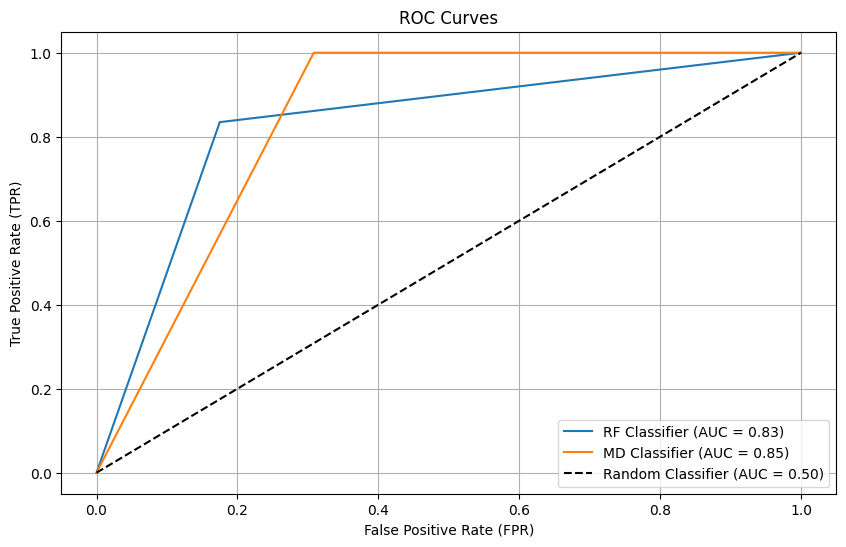

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Columns containing actual labels and predictions
true_labels = results_df["land_class"]  # Actual labels (0 or 1 for flooding)
rf_predictions = results_df["RF_prediction"]  # RF predictions
md_predictions = results_df["MD_prediction"]  # MD predictions

# Compute ROC curves and AUC for RF
fpr_rf, tpr_rf, thresholds_rf = roc_curve(true_labels, rf_predictions)
auc_rf = roc_auc_score(true_labels, rf_predictions)

# Compute ROC curves and AUC for MD
fpr_md, tpr_md, thresholds_md = roc_curve(true_labels, md_predictions)
auc_md = roc_auc_score(true_labels, md_predictions)

# Display AUC values
print("AUC Value :")
print(f"Random Forest (RF): {auc_rf:.2f}")
print(f"Minimum Distance (MD): {auc_md:.2f}")

# Display ROC curve points (FPR, TPR, and thresholds)
print("\nROC Curve Points for RF:")
for fpr, tpr, threshold in zip(fpr_rf, tpr_rf, thresholds_rf):
    print(f"Threshold: {threshold:.2f}, FPR: {fpr:.2f}, TPR: {tpr:.2f}")

print("\nROC Curve Points for MD:")
for fpr, tpr, threshold in zip(fpr_md, tpr_md, thresholds_md):
    print(f"Threshold: {threshold:.2f}, FPR: {fpr:.2f}, TPR: {tpr:.2f}")

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, label=f"RF Classifier (AUC = {auc_rf:.2f})")
plt.plot(fpr_md, tpr_md, label=f"MD Classifier (AUC = {auc_md:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves")
plt.legend(loc="best")
plt.grid()
plt.show()



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score


# Prepare data (adjust according to your dataset)
# Load validation samples from your script
Sample_LS_DATA = Sample_LS.getInfo()  # Ensure that validation_samples is already defined
data = Sample_LS_DATA ["features"]
data = pd.DataFrame([feat["properties"] for feat in data])
X = data[[polarization]]  # Feature columns
y = data["land_class"]               # Target column

# Define stratified cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
f1_scores_rf = []
balanced_accuracies_rf = []

f1_scores_md = []
balanced_accuracies_md = []

# Loop through each fold
for train_index, test_index in kfold.split(X, y):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 1. Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    # Compute metrics
    f1_scores_rf.append(f1_score(y_test, y_pred_rf))
    balanced_accuracies_rf.append(balanced_accuracy_score(y_test, y_pred_rf))

    # 2. Minimum Distance Classifier
    from sklearn.neighbors import NearestCentroid
    md_model = NearestCentroid(metric='euclidean')  # Minimum distance-based classifier
    md_model.fit(X_train, y_train)
    y_pred_md = md_model.predict(X_test)

    # Compute metrics
    f1_scores_md.append(f1_score(y_test, y_pred_md))
    balanced_accuracies_md.append(balanced_accuracy_score(y_test, y_pred_md))

# Final results (mean and standard deviation)
print("Random Forest:")
print(f"F1-score: {np.mean(f1_scores_rf):.2f} ± {np.std(f1_scores_rf):.2f}")
print(f"Balanced Accuracy: {np.mean(balanced_accuracies_rf):.2f} ± {np.std(balanced_accuracies_rf):.2f}")

print("\nMinimum Distance:")
print(f"F1-score: {np.mean(f1_scores_md):.2f} ± {np.std(f1_scores_md):.2f}")
print(f"Balanced Accuracy: {np.mean(balanced_accuracies_md):.2f} ± {np.std(balanced_accuracies_md):.2f}")



Random Forest:
F1-score: 0.86 ± 0.01
Balanced Accuracy: 0.86 ± 0.01

Minimum Distance:
F1-score: 0.88 ± 0.01
Balanced Accuracy: 0.86 ± 0.02


**Uncertainty map to visualize model agreement**

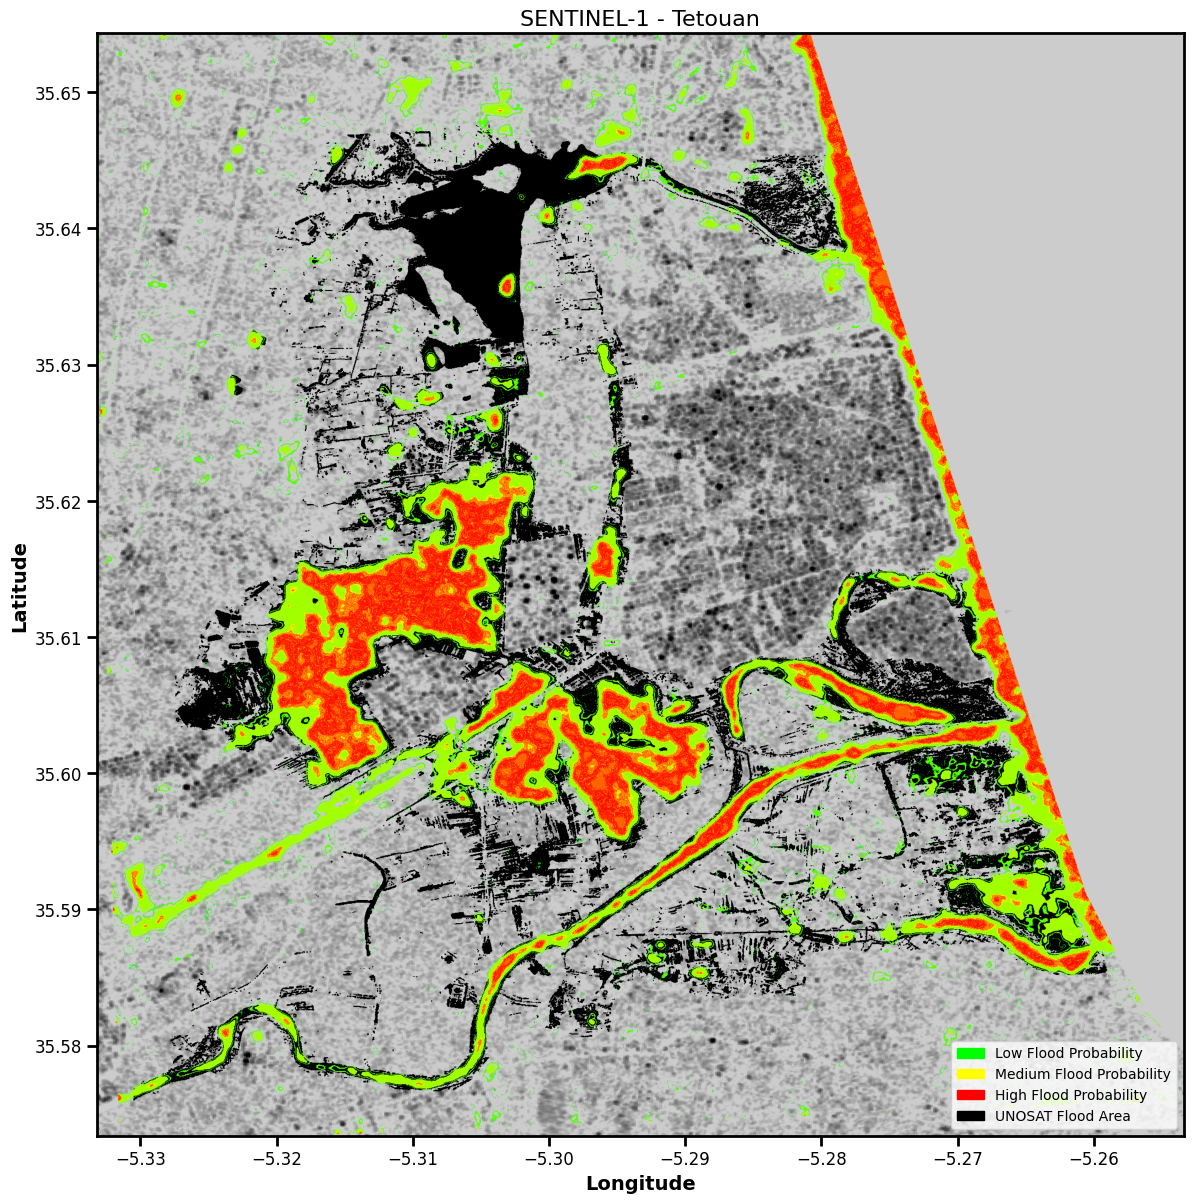

In [18]:
# MD without probability
classifier_MD = ee.Classifier.minimumDistance()
trained_MD = classifier_MD.train(features=Sample_LS, classProperty="land_class", inputProperties=bandNamesS1)
classified_MD = allcollection.classify(trained_MD)
flood_class_MD = classified_MD.eq(1).rename('MD_binary').toFloat()

# RF with probability
classifier_RF = ee.Classifier.smileRandomForest(50).setOutputMode('PROBABILITY')
trained_RF = classifier_RF.train(features=Sample_LS, classProperty="land_class", inputProperties=bandNamesS1)
probabilities_RF = allcollection.classify(trained_RF)
flood_prob_RF = probabilities_RF.select('classification').rename('RF_prob')  # flood class is '1'

# Combine RF probability with MD classification
combined_prob = flood_prob_RF.add(flood_class_MD).divide(2).rename('Combined_Prob')

# Compute median composite
sentinel1_image = after_S1_date.median()
# Prepare grayscale visualization (VV as single-band grayscale)
gray_vis_s1 = sentinel1_image.visualize(min=-20, max=0, palette=['#cccccc', '#000000'])


# Visualize flood extent
flood_layer = water_extent_area.style(color='000000', fillColor='000000', width=1)

# Style MD flood mask (binary classification): show only where MD says flood = 1
md_flood_styled = flood_class_MD.updateMask(flood_class_MD.eq(1)).visualize(palette=['#FFFF00'], opacity=1)

#Mask flood probability below threshold
flood_threshold = 0.3

flood_masked = flood_prob_RF.updateMask(flood_prob_RF.gte(flood_threshold))
#Visualize only strong flood probabilities
rf_flood_vis = flood_masked.visualize(min=flood_threshold, max=1, palette=['#008000'])

# Mask out low probability areas
combined_prob_masked = combined_prob.updateMask(combined_prob.gt(flood_threshold))

# Visualize only medium and high probabilities in blue
combined_prob_vis_blue = combined_prob_masked.visualize(min=flood_threshold,max=1,palette=['#3399ff', '#0000FF'])  # blue ramp

# Visualize Low, Medium, High probabilities
combined_prob_vis = combined_prob_masked.visualize(min=flood_threshold,max=1,palette=['#00FF00', '#FFFF00', '#FF0000'])
#Create a constant gray RGB image (e.g., RGB = 150,150,150 → medium gray)
gray_rgb = ee.Image.constant([150, 150, 150]).toUint8().rename(['R', 'G', 'B'])
#Clip the gray image to your study region to avoid covering global area
gray_background = gray_rgb.clip(geometry_area)
#Visualize it as an RGB image
gray_vis = gray_background.visualize(min=0, max=255)

# Combine all layers
#composite = ee.Image().blend(gray_vis).blend(flood_layer).blend(combined_prob_vis_blue)
#composite = ee.Image().blend(gray_vis).blend(flood_layer).blend(md_flood_styled).blend(rf_flood_vis)
#composite = ee.Image().blend(gray_vis).blend(flood_layer).blend(md_flood_styled)
#composite = ee.Image().blend(gray_vis).blend(flood_layer).blend(rf_flood_vis)

###################################################################################
composite = ee.Image().blend(gray_vis_s1).blend(flood_layer).blend(combined_prob_vis)

# Export parameters
scale = 30  # meters per pixel
dimensions = 2000  # pixel width/height for high resolution
region = geometry_area.geometry()

# Get thumbnail URL
url = composite.getThumbURL({
    'region': region,
    'dimensions': dimensions,
    'format': 'png'
})

# preview in notebook using matplotlib
import requests
from PIL import Image
from io import BytesIO
import matplotlib.patches as mpatches

response = requests.get(url)
img = Image.open(BytesIO(response.content))

# 1. Get bounding box coordinates from geometry
bounds = region.bounds().coordinates().getInfo()[0]

# Extract min/max lon/lat
lons = [point[0] for point in bounds]
lats = [point[1] for point in bounds]
min_lon, max_lon = min(lons), max(lons)
min_lat, max_lat = min(lats), max(lats)

# 2. Show image with geographic extent
plt.figure(figsize=(12, 12))
plt.imshow(img, extent=[min_lon, max_lon, min_lat, max_lat])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.title("SENTINEL-1 - Matam", fontsize=16)
plt.title("SENTINEL-1 - Tetouan", fontsize=16)
#plt.title("SENTINEL-1 - MD", fontsize=16)
#plt.title("SENTINEL-1 - RF", fontsize=16)
#plt.title("SENTINEL-1 - RF & MD", fontsize=16)
#plt.title("PLEIADES", fontsize=16)

# 3. Add legend
legend_patches = [
    #mpatches.Patch(color='#008000', label='Random Forest Flood'),
    #mpatches.Patch(color='#FFFF00', label='Minimum Distance Flood'),
    #mpatches.Patch(color='#0000FF', label='RF & MD Flood'),
    mpatches.Patch(color='#00FF00', label='Low Flood Probability'),
    mpatches.Patch(color='#FFFF00', label='Medium Flood Probability'),
    mpatches.Patch(color='#FF0000', label='High Flood Probability'),
    mpatches.Patch(color='#000000', label='UNOSAT Flood Area')
]
plt.legend(handles=legend_patches, loc='lower right', fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig("final_flood_map_with_coords.png", dpi=300)

import matplotlib.patches as mpatches
# Customize axis labels and aesthetics
ax = plt.gca()
ax.set_xlabel("Longitude", fontsize=14, weight='bold')
ax.set_ylabel("Latitude", fontsize=14, weight='bold')

# Make ticks thicker and change font
ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=7)
ax.tick_params(axis='both', which='minor', width=1, length=4)

# Make axis lines (spines) thicker
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Set background color to white for cleaner output
ax.set_facecolor('white')

plt.show()


**Combined Flooded Area Calculation from RF and MD Classifiers**

In [ ]:
# Training Minimum Distance Classifiers
MD_classifier = ee.Classifier.minimumDistance().train(
    features=Sample_LS,
    classProperty="land_class",
    inputProperties=bandNamesS1
)
# Apply the classifier
MD_classification= allcollection.classify(MD_classifier)

###########################################################################
#Training Random Forest Classifiers
RF_classifier = ee.Classifier.smileRandomForest(50).train(
    features=Sample_LS,
    classProperty="land_class",
    inputProperties=bandNamesS1
)

# Apply the classifier
RF_classification= allcollection.classify(RF_classifier)

combined_classification = RF_classification.eq(1).Or(MD_classification.eq(1))

# Calculate the area of flooded zones
pixel_area_RF = RF_classification.multiply(ee.Image.pixelArea())
# Calculate the total flooded area
total_flooded_area_RF = pixel_area_RF.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=10,
    maxPixels=1e13
)
# Convert to hectares
flooded_area_ha_RF = ee.Number(total_flooded_area_RF.get("classification")).divide(10000)
print("Total extent of detected water surface (ha)-RF:", flooded_area_ha_RF.getInfo())

###########################################################################################
pixel_area_MD = MD_classification.multiply(ee.Image.pixelArea())
# Calculate the total flooded area
total_flooded_area_MD = pixel_area_MD.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=10,
    maxPixels=1e13
)
# Convert to hectares
flooded_area_ha_MD = ee.Number(total_flooded_area_MD.get("classification")).divide(10000)
print("Total extent of detected water surface (ha)-MD:", flooded_area_ha_MD.getInfo())


###########################################################################################
pixel_area = combined_classification.multiply(ee.Image.pixelArea())
# Calculate the total flooded area
total_flooded_area = pixel_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=geometry_area,
    scale=10,
    maxPixels=1e13
)
# Convert to hectares
flooded_area_ha = ee.Number(total_flooded_area.get("classification")).divide(10000)
print("Total extent of detected water surface (ha)- RF & MD :", flooded_area_ha.getInfo())

################################################# Extent permanentWater ###################
#the Copernicus Global Land Service (CGLS) land cover map (100m)
CGLS=ee.Image("COPERNICUS/Landcover/100m/Proba-V-C3/Global/2019")
landcover = CGLS.select('discrete_classification')
landcover_area = landcover.clip(geometry_area)

#Extract only water pixels from CGLS using class value equal to 80 or 200
water = landcover_area.eq(80).Or(landcover_area.eq(200))

#extent permanentWater
inundation_area_PW = water.multiply(ee.Image.pixelArea())

# Sum the area covered by inundated pixels.
inundation_stats_PW = inundation_area_PW.reduceRegion (
   reducer= ee.Reducer.sum(),
   geometry= geometry_area,
   scale= 10,
   maxPixels= 1e13,
   bestEffort= True
  )
# Convertir PW en hectares
PW_area_ha = ee.Number(inundation_stats_PW.get("discrete_classification")).divide(10000)
print("Permanent water extent (ha):", PW_area_ha.getInfo())
###############################################################################################
#Total flooded surface
surf_total_RF=flooded_area_ha_RF.subtract(PW_area_ha)
print("Total flood surface (ha)-RF :", surf_total_RF.getInfo())
surf_total_MD=flooded_area_ha_MD.subtract(PW_area_ha)
print("Total flood surface (ha)-MD :", surf_total_MD.getInfo())
surf_total=flooded_area_ha.subtract(PW_area_ha)
print("Total flood surface (ha)-RF & MD :", surf_total.getInfo())


Total extent of detected water surface (ha)-RF: 16049.2632845795
Total extent of detected water surface (ha)-MD: 23837.94488634692
Total extent of detected water surface (ha)- RF & MD : 23837.94488634692
Permanent water extent (ha): 1447.6674091409004
Total flood surface (ha)-RF : 14601.595875432497
Total flood surface (ha)-MD : 22390.27747720602
Total flood surface (ha)-RF & MD : 22390.277477199914


**Area Calculation for Water Extent Features( UNOSAT)**

In [ ]:
# Calculate the areas in square meters for each entity and add as a property
water_extent_area_with_area = water_extent_area.map(lambda feature:
    feature.set({'area_m2': feature.geometry().area()}))

# Extract the sum of the areas
total_area_m2 = water_extent_area_with_area.aggregate_sum('area_m2')

# Convert to hectares
total_area_ha = total_area_m2.divide(10000)

# Print the result
print("Total area in hectares:", total_area_ha.getInfo())

Area_Difference = total_area_ha.subtract(surf_total).abs()
print("Area difference :", Area_Difference.getInfo())


Total area in hectares: 52755.82702233238
Area difference : 30365.549545132464


In [ ]:
# ********************************* Display each image before and after *********************************
def add_image(image):
    image_id = image['id']
    image2 = ee.Image(image_id)
    #print(f"Adding image {image_id}")
    # Here, add the layer with your custom visualization if needed
    Map.addLayer(image2, {'min': -25, 'max': 0}, f"Image {image_id}")

# Create a map and display the results
Map = geemap.Map()
Map.centerObject(geometry_area, 10)

# Evaluate and iterate through the before and after images
#before_S1_date_list = before_S1_date.toList(before_S1_date.size()).getInfo()
#after_S1_date_list = after_S1_date.toList(after_S1_date.size()).getInfo()

#for image in before_S1_date_list: add_image(image)
#for image in after_S1_date_list: add_image(image)

#Map.add_basemap("Esri.NatGeoWorldMap")
#Map.add_basemap("SATELLITE")
#Map.add_basemap("BaseMapDE.Color")

# Add flooded areas
Map.addLayer(water_extent_area, {}, "Zone Inondées unosat", 1)

Map.addLayer(combined_classification.updateMask(combined_classification), {'palette': 'red'}, 'Combined Flood', 0)
Map.addLayer(MD_classification.updateMask(MD_classification.eq(1)), {'palette': 'yellow'}, 'Minimum Distance Flood', 1)
Map.addLayer(RF_classification.updateMask(RF_classification.eq(1)), {'palette': 'green'}, 'Random Forest Flood', 1)
#Add reference data points into the map to visualize
Map.addLayer(water_data.draw("blue"),{},"water",0)
Map.addLayer(other_data.draw("yellow"),{},"other",0)

Map.addLayer(water.selfMask(), {'palette': 'blue'}, 'Permanent water', 1)
# Add the study area
Map.addLayer(geometry_area, {}, "Study area", 0)
# Display the map
Map.to_html("map_senegal_matam_MD_RF_S1_400_water.html")
# Map.to_html("map_tetouan_morocco_MD_RF_S1_400_water.html")
print("Map saved!")
Map

Map saved!


Map(center=[15.612321529421237, -13.22149679022003], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:

task = ee.batch.Export.image.toDrive(
    image=combined_classification,
    description="classification_MD_RF_senegal_matam_S1_200pt_water_20241020",
     #description="classification_MD_RF_tetouan_morocco_S1_400pt_water",
    folder="GEE_Exports",
    fileNamePrefix="classification_Md_RF_senegal_matam_S1_200pt_water_20241020",
    #fileNamePrefix="classification_Md_RF_tetouan_morocco_S1_400pt_water",
    region=geometry_area.geometry(),
    scale=10,
    crs='EPSG:4326',
    maxPixels=1e13
)
task.start()


**Calculating IoU,Overlap Percentage,Commission Error and Omission Errors**


In [ ]:
from osgeo import gdal

def align_rasters(reference_path, target_path, output_path):
    """Align the target raster to match the reference raster."""
    reference = gdal.Open(reference_path)
    target = gdal.Open(target_path)

    reference_proj = reference.GetProjection()
    reference_geotransform = reference.GetGeoTransform()
    x_res = reference.RasterXSize
    y_res = reference.RasterYSize

    driver = gdal.GetDriverByName("GTiff")
    aligned_target = driver.Create(
        output_path,
        x_res,
        y_res,
        1,
        gdal.GDT_Int32
    )

    aligned_target.SetGeoTransform(reference_geotransform)
    aligned_target.SetProjection(reference_proj)

    gdal.ReprojectImage(
        target,
        aligned_target,
        target.GetProjection(),
        reference_proj,
        gdal.GRA_NearestNeighbour
    )
    aligned_target.FlushCache()

def calculate_metrics(reference_path, aligned_target_path):
    """Calculate intersection, union, IoU, overlap percentage, commission error, and omission error."""
    with rasterio.open(reference_path) as ref_src:
        ref_array = ref_src.read(1)
        ref_array = np.where(ref_array == ref_src.nodata, 0, ref_array)
        ref_array = np.where(ref_array == 1, 1, 0)  # Binary water mask

    with rasterio.open(aligned_target_path) as tgt_src:
        tgt_array = tgt_src.read(1)
        tgt_array = np.where(tgt_array == tgt_src.nodata, 0, tgt_array)
        tgt_array = np.where(tgt_array == 1, 1, 0)  # Binary water mask

        print(f"Benchmark map: {ref_array.sum()}")
        print(f"Prediction map: {tgt_array.sum()}")

    # Calculate Intersection and Union
    intersection = np.logical_and(ref_array, tgt_array).sum()
    union = np.logical_or(ref_array, tgt_array).sum()

    # IoU Calculation
    iou = (intersection / union) * 100 if union != 0 else 0

    # Overlap Percentage Calculation
    overlap_percentage = (intersection / ref_array.sum()) * 100 if ref_array.sum() != 0 else 0

    # Commission Error: False Positives / (True Positives + False Positives)
    false_positives = np.logical_and(tgt_array == 1, ref_array == 0).sum()
    true_positives = intersection
    commission_error = false_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0

    # Omission Error: False Negatives / (True Positives + False Negatives)
    false_negatives = np.logical_and(tgt_array == 0, ref_array == 1).sum()
    omission_error = false_negatives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0

    return intersection, union, iou, overlap_percentage, commission_error, omission_error

# File paths
benchmark_map_path = "/content/drive/MyDrive/GEE_Exports/WaterExtent_MatamDepartment_PolygonToRaster_20241020.tif"
predicted_map_path = "/content/drive/MyDrive/GEE_Exports/SENTINEL-1/classification_Md_RF_senegal_matam_S1_400pt_water.tif"
aligned_predicted_path = "/content/drive/MyDrive/GEE_Exports/SENTINEL-1/aligned_predicted_Md_RF_senegal_matam_S1_400pt_water.tif"


 #benchmark_map_path = '/content/drive/MyDrive/GEE_Exports/WaterExtent_Tetouan_PolygonToRaster_Pleiades.tif'
 #predicted_map_path = '/content/drive/MyDrive/GEE_Exports/SENTINEL-1/classification_Md_RF_tetouan_morocco_S1_400pt_water.tif'
 #aligned_predicted_path = "/content/drive/MyDrive/GEE_Exports/SENTINEL-1/aligned_predicted_Md_RF_tetouan_morocco_S1_400pt_water.tif"


# Step 1: Align rasters
align_rasters(benchmark_map_path, predicted_map_path, aligned_predicted_path)

# Step 2: Calculate metrics
intersection, union, iou, overlap_percentage, commission_error, omission_error = calculate_metrics(benchmark_map_path, aligned_predicted_path)

# Step 3: Print results
print("Metrics:")
print(f"Intersection: {intersection}")
print(f"Union: {union}")
print(f"IoU: {iou:.2f}%")
print(f"Overlap Percentage: {overlap_percentage:.2f}%")
print(f"Commission Error: {commission_error * 100:.2f}%")
print(f"Omission Error: {omission_error * 100:.2f}%")


Benchmark map: 4430256
Prediction map: 1887570
Metrics:
Intersection: 1428722
Union: 4889104
IoU: 29.22%
Overlap Percentage: 32.25%
Commission Error: 24.31%
Omission Error: 67.75%
